# Test on Controllability and Robustness on Name Pair Task

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [2]:
import torch
import torchtext
from lightning.pytorch.loggers.wandb import WandbLogger
import torchmetrics

import numpy as np
import wandb
import torchinfo
from contextlib import nullcontext
from  tqdm import tqdm, trange
import argparse


import sys; sys.path += ['..']
from language_models import TransformerLM, configure_optimizers

## Config

In [3]:
args = argparse.Namespace(
    batch_size=32, n_epochs=60, log_on_step=True,
    wandb_project="controllability-robustness-test", run_name='hello', 
    n_layers=3, n_heads=4, d_model=128, dff=128*4)

In [4]:
# region some configuration
device = 'cuada'
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
# dtype = 'float32'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)
# wandb logging
wandb_log = False
wandb_project = args.wandb_project
# endregion


## Data

In [5]:

# get data and vocab for the first 1000 samples
data_path = '../name_pairs_dataset/full-sentences.txt'
with open(data_path) as f:
    data = f.read().splitlines()[:200]
    last_names = [x.split(' ')[-1] for x in data]

with open('../name_pairs_dataset/first-names.txt') as f:
    first_names = f.read().splitlines()[:200]


# create vocab map
vocab = first_names + last_names
vocab = [x.lower() for x in vocab]
vocab += ['has', 'last', 'name', '[UNK]', '[sep]']
vocab = list(set(vocab))

vocab_map = {vocab: i for i, vocab in enumerate(vocab)}

vocab_size = len(vocab)
print('vocab size: ', vocab_size) # vocab size is very large; especially for a task this simple

#tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

test_data_counterfactual = [f'{" ".join(sentence.split(" ")[:-1])} {last_names[np.random.randint(len(last_names))]}' for sentence in data]
test_data_counterfactual = [f'{sentence} [SEP] {sentence}' for sentence in test_data_counterfactual]

# sample different first and last names
test_data_counterfactual_irrelevant = [f'{first_names[np.random.randint(len(first_names))]} {" ".join(sentence.split(" ")[1:])}' for sentence in data]
test_data_counterfactual_irrelevant = [f'{" ".join(sentence.split(" ")[:-1])} {last_names[np.random.randint(len(last_names))]}' for sentence in test_data_counterfactual_irrelevant]
test_data_counterfactual_irrelevant = [f'{test_data_counterfactual_irrelevant[i]} [SEP] {data[i]}' for i in range(len(data))]
print(test_data_counterfactual_irrelevant[:5])
print(test_data_counterfactual[-5:])
# modify sentence to include [SEP] token
data = [f'{sentence} [SEP] {sentence}' for sentence in data]

# create test data, substitute last name with another randomly selected last name


tokenized_data = [sentence.strip().lower().split(' ') for sentence in tqdm(data)]
test_tokenized_data_counterfactual = [sentence.strip().lower().split(' ') for sentence in tqdm(test_data_counterfactual)]
test_tokenized_data_counterfactual_irrelevant = [sentence.strip().lower().split(' ') for sentence in tqdm(test_data_counterfactual_irrelevant)]

integer_ids = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(tokenized_data)]
integer_ids = torch.tensor(np.array(integer_ids))
integer_test_ids_counterfactual = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(test_tokenized_data_counterfactual)]
integer_test_ids_counterfactual = torch.tensor(np.array(integer_test_ids_counterfactual))
integer_test_ids_counterfactul_irrelevant = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(test_tokenized_data_counterfactual_irrelevant)]
integer_test_ids_counterfactul_irrelevant = torch.tensor(np.array(integer_test_ids_counterfactul_irrelevant))


# create dataset and dataloader
x = integer_ids[:, :-1]
y = integer_ids[:, 1:]
x_test_counterfactual = integer_test_ids_counterfactual[:, :-1]
y_test_counterfactual = integer_test_ids_counterfactual[:, 1:]
x_test_counterfactual_irrelevant = integer_test_ids_counterfactul_irrelevant[:, :-1]
y_test_counterfactual_irrelevant = integer_test_ids_counterfactul_irrelevant[:, 1:]


x_train, y_train, x_val, y_val = x[:100], y[:100], x[100:200], y[100:200]
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
val_dataset = torch.utils.data.TensorDataset(x_val, y_val)

test_dataset_counterfactual = torch.utils.data.TensorDataset(x_test_counterfactual, y_test_counterfactual)
test_dataset_counterfactual_irrelevant = torch.utils.data.TensorDataset(x_test_counterfactual_irrelevant, y_test_counterfactual_irrelevant)

test_dataset_counterfactual = torch.utils.data.TensorDataset(*test_dataset_counterfactual[:100])
test_dataset_counterfactual_irrelevant = torch.utils.data.TensorDataset(*test_dataset_counterfactual_irrelevant[:100])

train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
test_dl_counterfactual = torch.utils.data.DataLoader(test_dataset_counterfactual, batch_size=args.batch_size, shuffle=False)
test_dl_counterfactual_irrelevant = torch.utils.data.DataLoader(test_dataset_counterfactual_irrelevant, batch_size=args.batch_size, shuffle=False)
seq_len = x.shape[1]

vocab size:  404
['Adrian has last name WIGGLESWORTH [SEP] Aaren has last name DURLAND', 'Adi has last name POLACCO [SEP] Aarika has last name ROBITAILLE', 'Agatha has last name RUFFO [SEP] Abagael has last name SJOGREN', 'Almeda has last name HERARD [SEP] Abagail has last name MENGSTEAB', 'Aleen has last name FORRY [SEP] Abbe has last name OEHLENSCHLAGE']
['Alyss has last name COLEBROOK [SEP] Alyss has last name COLEBROOK', 'Alyssa has last name THATCHER [SEP] Alyssa has last name THATCHER', 'Amabel has last name TODY [SEP] Amabel has last name TODY', 'Amabelle has last name KLOCKE [SEP] Amabelle has last name KLOCKE', 'Amalea has last name HALLOWICH [SEP] Amalea has last name HALLOWICH']


100%|██████████| 200/200 [00:00<00:00, 29243.88it/s]

## Model

In [6]:
import lightning as L
import matplotlib.pyplot as plt

class LitLanguageModel(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.mismatched_sequences = []

    def training_step(self, batch, batch_idx):
        x, y = batch
        # with ctx:
        logits, loss = self.model(x, y)

        self.log('train_loss', loss, prog_bar=True, logger=True, on_step=args.log_on_step, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        # with ctx:
        logits, loss = self.model(x, y)

        perplexity = torchmetrics.functional.text.perplexity(logits, y)

        self.log(f"val_loss", loss, prog_bar=True, logger=True, add_dataloader_idx=False)
        self.log(f'val_perplexity', perplexity, prog_bar=True, logger=True, add_dataloader_idx=False)

    def test_step(self, batch, batch_idx):
        x, y = batch
        # with ctx:
        logits, loss = self.model(x, y)

        perplexity = torchmetrics.functional.text.perplexity(logits, y)

        self.log(f"test_loss", loss, prog_bar=True, logger=True, add_dataloader_idx=False)
        self.log(f'test_perplexity', perplexity, prog_bar=True, logger=True, add_dataloader_idx=False)
        
        # Calculate per position accuracy
        per_pos_acc = self.per_position_accuracy(logits, y)  
        
        # Calculate whole sequence accuracy
        seq_acc = self.sequence_accuracy(logits, y)
        
        # Log both metrics
        self.log('test_seq_acc', seq_acc, on_step=True, on_epoch=True)
        self.log('test_per_pos_acc_mean', per_pos_acc.mean(), on_step=True, on_epoch=True)
        
        # plot per position accuracy
        plt.plot(per_pos_acc.cpu().numpy())
        
        self.capture_mismatches(logits, y, x)
        
    def sequence_accuracy(self, preds, targets):
        # Convert logits to predictions
        preds = torch.argmax(preds, dim=-1)
        # Check if entire sequences match
        correct = torch.all(preds == targets, dim=1)
        accuracy = torch.mean(correct.float())
        return accuracy
    
    def per_position_accuracy(self, logits, targets):
        preds = torch.argmax(logits, dim=-1)
        correct = preds == targets
        per_position_acc = correct.float().mean(dim=0)
        return per_position_acc
    
    def capture_mismatches(self, preds, targets, inputs, max_examples=1000):
        """
        Store examples of sequences where the predictions do not match the targets.
        
        Args:
            preds (torch.Tensor): The model's predicted sequences.
            targets (torch.Tensor): The actual sequences.
            inputs (torch.Tensor): The input sequences to the model.
            max_examples (int): Maximum number of mismatched sequences to store.
        """
        # Convert predictions to class indices
        preds = torch.argmax(preds, dim=-1)
        mismatches = preds != targets
        
        # Iterate over the batch to find mismatches
        for i in range(mismatches.size(0)):
            if torch.any(mismatches[i]) and len(self.mismatched_sequences) < max_examples:
                mismatch_data = {
                    'input': inputs[i].cpu().numpy(),
                    'predicted': preds[i].cpu().numpy(),
                    'target': targets[i].cpu().numpy()
                }
                self.mismatched_sequences.append(mismatch_data)
                
        
                
    # def on_test_epoch_end(self):
    #     # Already stored mismatched sequences in self.mismatched_sequences
    #     if self.mismatched_sequences:
    #         print("Mismatched Sequences:")
    #         for i, mismatch in enumerate(self.mismatched_sequences, 1):
    #             print(f"\nMismatch {i}:")
    #             print(f"Input: {mismatch['input']}")
    #             print(f"Predicted: {mismatch['predicted']}")
    #             print(f"Target: {mismatch['target']}")
    #     else:
    #         print("No mismatches found or mismatches not captured.")




    def configure_optimizers(self):
        # NOTE: i chose these arbitrarily; may need to be tuned
        optimizer = configure_optimizers(self.model, weight_decay=0.0, learning_rate=1e-3, betas=(0.9, 0.999), device_type="cuda" if torch.cuda.is_available() else "cpu")
        return optimizer

In [7]:
d_model = args.d_model # 128
dff = args.dff # 256
n_layers = args.n_layers
n_heads = args.n_heads
dropout_rate = 0.1
activation = 'gelu'
norm_first = True


model_args = dict(
    vocab_size=vocab_size, d_model=d_model, n_layers=n_layers, n_heads=n_heads, dff=dff,
    dropout_rate=dropout_rate, activation=activation, norm_first=norm_first, max_block_size=seq_len)
model = TransformerLM(**model_args)#.to(device)
torchinfo.summary(model, row_settings=["depth", "var_names"], col_names=["num_params", "params_percent", "trainable"], depth=3, col_width=20)

Layer (type (var_name):depth-idx)                                           Param #              Param %              Trainable
TransformerLM (TransformerLM)                                               --                        --              True
├─ModuleDict (layers): 1-1                                                  --                        --              True
│    └─Embedding (token_embedder): 2-1                                      51,712                 7.39%              True
│    │    └─Linear (weights): 3-1                                           52,116                 7.45%              True
│    └─Embedding (positional_embedder): 2-2                                 1,280                  0.18%              True
│    └─Dropout (dropout): 2-3                                               --                        --              --
│    └─ModuleList (blocks): 2-4                                             --                        --              True
│    │    └─E

In [8]:
lit_model = LitLanguageModel(model)

In [9]:
n_epochs = args.n_epochs

# run = wandb.init(project=wandb_project, group=group_name, name=run_name,
    # config={'group': group_name, **model_args})

# wandb_logger = WandbLogger(experiment=run, log_model=False) # name=run_name, project=wandb_project,
# wandb_logger.watch(model, log_graph=False)
wandb_logger = None
callbacks = [
    L.pytorch.callbacks.TQDMProgressBar(refresh_rate=50)
    # L.pytorch.callbacks.RichProgressBar()
]
trainer = L.Trainer(
    max_epochs=n_epochs, enable_checkpointing=False, enable_model_summary=True, #precision='64-true',
    callbacks=callbacks, enable_progress_bar=True, check_val_every_n_epoch=1, # limit_train_batches=200, limit_val_batches=200,
    logger=False
    )
trainer.fit(model=lit_model, train_dataloaders=train_dl, val_dataloaders=val_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params
----------------------------------------
0 | model | TransformerLM | 699 K 
----------------------------------------
699 K     Trainable params
0         Non-trainable params
699 K     Total params
2.800     Total estimated model params size (MB)


num decayed parameter tensors: 15, with 694,528 parameters
num non-decayed parameter tensors: 25, with 5,396 parameters
using fused AdamW: True


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/awni/miniconda3/envs/abstract_transformer/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/awni/miniconda3/envs/abstract_transformer/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/awni/miniconda3/envs/abstract_transformer/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('val_perplexity', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/awni/miniconda3/envs/abstract_transformer/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 't

Training: |          | 0/? [00:00<?, ?it/s]

/home/awni/miniconda3/envs/abstract_transformer/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=60` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/awni/miniconda3/envs/abstract_transformer/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/awni/miniconda3/envs/abstract_transformer/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

/home/awni/miniconda3/envs/abstract_transformer/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('test_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/awni/miniconda3/envs/abstract_transformer/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('test_perplexity', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_loss          │    0.0012634966988116503    │
│ test_per_pos_acc_mean_epoch │             1.0             │
│       test_perplexity       │     1.0012643337249756      │
│     test_seq_acc_epoch      │             1.0             │
└─────────────────────────────┴─────────────────────────────┘

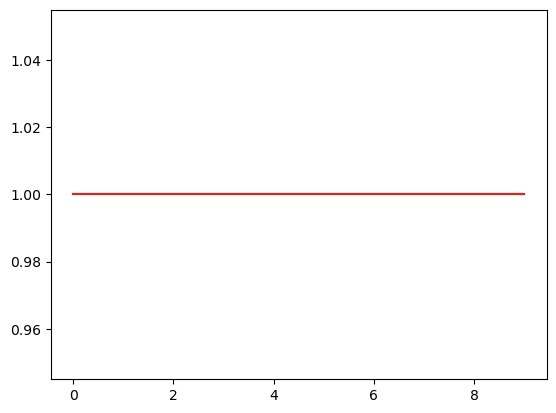

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_loss          │      3.618100166320801      │
│ test_per_pos_acc_mean_epoch │      0.699999988079071      │
│       test_perplexity       │      37.37565231323242      │
│     test_seq_acc_epoch      │             0.0             │
└─────────────────────────────┴─────────────────────────────┘

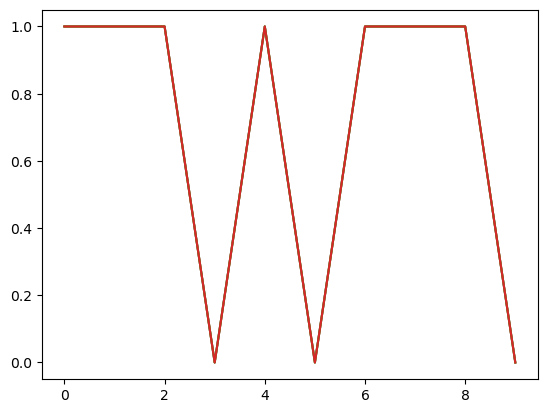

In [10]:
# model performance on the training set
trainer.test(model=lit_model, dataloaders=train_dl)
plt.show()
# model performance on the validation set
trainer.test(model=lit_model, dataloaders=val_dl)
plt.show()


## Test on counterfactual context

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_loss          │      3.447951316833496      │
│ test_per_pos_acc_mean_epoch │     0.7649999856948853      │
│       test_perplexity       │     31.552398681640625      │
│     test_seq_acc_epoch      │             0.0             │
└─────────────────────────────┴─────────────────────────────┘

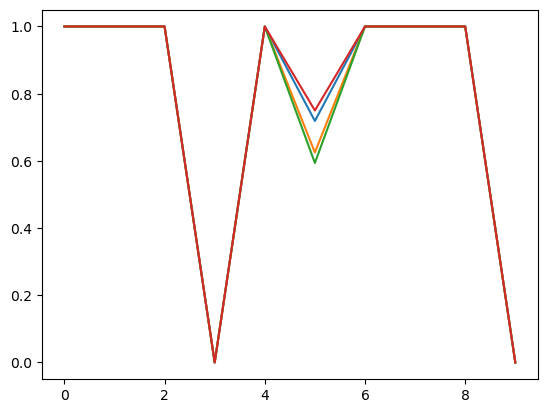

Input: aaren has last name gibble [sep] aaren has last name
Predicted: has last name durland [sep] aaren has last name durland
Target: has last name gibble [sep] aaren has last name gibble
Pretrained Knowledge:
aaren has last name durland
amabelle has last name gibble 

Input: aarika has last name wahlstrom [sep] aarika has last name
Predicted: has last name robitaille [sep] aarika has last name robitaille
Target: has last name wahlstrom [sep] aarika has last name wahlstrom
Pretrained Knowledge:
aarika has last name robitaille
agnes has last name wahlstrom 

Input: abagael has last name aubertine [sep] abagael has last name
Predicted: has last name sjogren [sep] abra has last name sjogren
Target: has last name aubertine [sep] abagael has last name aubertine
Pretrained Knowledge:
abagael has last name sjogren
abra has last name aubertine 

Input: abagail has last name aubertine [sep] abagail has last name
Predicted: has last name mengsteab [sep] abagail has last name mengsteab
Target: h

In [11]:
def decode_sequence(sequence, reverse_vocab_map):
    """Decode a sequence of IDs back to words using the reverse vocabulary map."""
    return ' '.join([reverse_vocab_map.get(token_id, '[UNK]') for token_id in sequence])


def mismatch_seq_print(mismatch, reverse_vocab_map):
    for mismatch in lit_model.mismatched_sequences[:5]:
        input_seq = decode_sequence(mismatch['input'], reverse_vocab_map)
        predicted_seq = decode_sequence(mismatch['predicted'], reverse_vocab_map)
        target_seq = decode_sequence(mismatch['target'], reverse_vocab_map)
        first_name = input_seq.split(' ')[0]
        last_name = target_seq.split(' ')[-1]
        # find last name of first name in training data
        # Capitalize the first character of the first name
        trained_last_name = last_names[first_names.index(first_name.capitalize())]
        trained_first_name = first_names[last_names.index(last_name.upper())]
        
        print(f"Input: {input_seq}")
        print(f"Predicted: {predicted_seq}")
        print(f"Target: {target_seq}")
        print("Pretrained Knowledge:")
        print(f"{first_name} has last name {trained_last_name.lower()}")
        print(f"{trained_first_name.lower()} has last name {last_name} \n")

lit_model.mismatched_sequences.clear()
reverse_vocab_map = {i: word for word, i in vocab_map.items()}
# test the model on the test set
trainer.test(model=lit_model, dataloaders=test_dl_counterfactual)
plt.show()
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)

## Test on irrelevant counterfactual context (both first and last name changed in context)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_loss          │      2.86027455329895       │
│ test_per_pos_acc_mean_epoch │     0.7050000429153442      │
│       test_perplexity       │     17.539148330688477      │
│     test_seq_acc_epoch      │             0.0             │
└─────────────────────────────┴─────────────────────────────┘

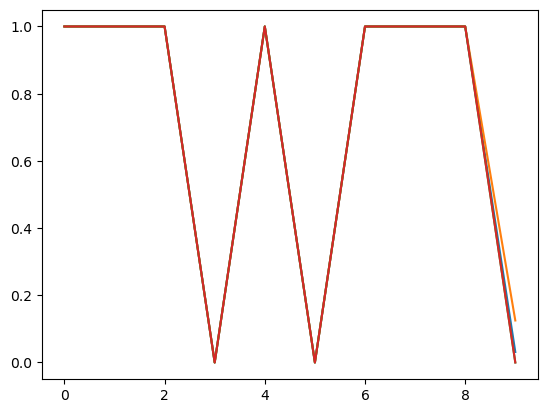

Input: adrian has last name wigglesworth [sep] aaren has last name
Predicted: has last name baniaga [sep] adrian has last name baniaga
Target: has last name wigglesworth [sep] aaren has last name durland
Pretrained Knowledge:
adrian has last name baniaga
wigglesworth has first name ainsley
adrian has last name baniaga 

Input: adi has last name polacco [sep] aarika has last name
Predicted: has last name berendzen [sep] adi has last name berendzen
Target: has last name polacco [sep] aarika has last name robitaille
Pretrained Knowledge:
adi has last name berendzen
polacco has first name ag
adi has last name berendzen 

Input: agatha has last name ruffo [sep] abagael has last name
Predicted: has last name arevalo [sep] abigale has last name arevalo
Target: has last name ruffo [sep] abagael has last name sjogren
Pretrained Knowledge:
agatha has last name arevalo
ruffo has first name alisha
abigale has last name villao 

Input: almeda has last name herard [sep] abagail has last name
Predict

In [12]:

def mismatch_seq_print_irrelevant(mismatch, reverse_vocab_map):
    
    for mismatch in lit_model.mismatched_sequences[:5]:
        input_seq = decode_sequence(mismatch['input'], reverse_vocab_map)
        predicted_seq = decode_sequence(mismatch['predicted'], reverse_vocab_map)
        target_seq = decode_sequence(mismatch['target'], reverse_vocab_map)
        first_name_ctx = input_seq.split(' ')[0]
        last_name_ctx = input_seq.split(" [sep] ")[0].split(' ')[-1]
        first_name_pred = predicted_seq.split(' [sep] ')[1].split(' ')[0]
        # find last name of first name in training data
        # Capitalize the first character of the first name
        trained_last_name = last_names[first_names.index(first_name_ctx.capitalize())]
        context_last_to_first_name = first_names[last_names.index(last_name_ctx.upper())]
        first_name_pred_last_name = last_names[first_names.index(first_name_pred.capitalize())]
        print(f"Input: {input_seq}")
        print(f"Predicted: {predicted_seq}")
        print(f"Target: {target_seq}")
        print("Pretrained Knowledge:")
        print(f"{first_name_ctx} has last name {trained_last_name.lower()}")
        print(f"{last_name_ctx} has first name {context_last_to_first_name.lower()}")
        print(f"{first_name_pred} has last name {first_name_pred_last_name.lower()} \n")


# test the model on the test set
lit_model.mismatched_sequences.clear()

trainer.test(model=lit_model, dataloaders=test_dl_counterfactual_irrelevant)
plt.show()
mismatch_seq_print_irrelevant(lit_model.mismatched_sequences, reverse_vocab_map)

## Test on empty context

In [13]:
test_data_empty_ctx = [f' [SEP] {sentence}' for sentence in data]
print(test_data_empty_ctx[:5])

tokenized_data = [sentence.strip().lower().split(' ') for sentence in tqdm(test_data_empty_ctx)]

integer_ids = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(tokenized_data)]
integer_ids = torch.tensor(np.array(integer_ids))


# create dataset and dataloader
x = integer_ids[:, :-1]
y = integer_ids[:, 1:]
test_dataset_empty_ctx = torch.utils.data.TensorDataset(x, y)
test_dataset_empty_ctx = test_dataset_empty_ctx[:100] # NOTE: smaller dataset for testing
test_dl_empty_ctx = torch.utils.data.DataLoader(test_dataset_empty_ctx, batch_size=args.batch_size, shuffle=False)




[' [SEP] Aaren has last name DURLAND [SEP] Aaren has last name DURLAND', ' [SEP] Aarika has last name ROBITAILLE [SEP] Aarika has last name ROBITAILLE', ' [SEP] Abagael has last name SJOGREN [SEP] Abagael has last name SJOGREN', ' [SEP] Abagail has last name MENGSTEAB [SEP] Abagail has last name MENGSTEAB', ' [SEP] Abbe has last name OEHLENSCHLAGE [SEP] Abbe has last name OEHLENSCHLAGE']


100%|██████████| 200/200 [00:00<00:00, 103601.43it/s]


In [14]:
def mismatch_seq_print_empty(mismatch, reverse_vocab_map):
    for mismatch in lit_model.mismatched_sequences:
        input_seq = decode_sequence(mismatch['input'], reverse_vocab_map)
        predicted_seq = decode_sequence(mismatch['predicted'], reverse_vocab_map)
        target_seq = decode_sequence(mismatch['target'], reverse_vocab_map)
        
        print(f"Input: {input_seq}")
        print(f"Predicted: {predicted_seq}")
        print(f"Target: {target_seq}")
        
# test the model on the test set
lit_model.mismatched_sequences.clear()

trainer.test(model=lit_model, dataloaders=test_dl_empty_ctx)
plt.show()
mismatch_seq_print_empty(lit_model.mismatched_sequences, reverse_vocab_map)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

AssertionError: Input sequence length 11 exceeds maximum block size 10

## Test on irrelevant counterfactual context (only first name changed in context)

In [ ]:
def mismatch_seq_print_irrelevant_first_name(mismatch, reverse_vocab_map):
    
    for mismatch in lit_model.mismatched_sequences[:5]:
        input_seq = decode_sequence(mismatch['input'], reverse_vocab_map)
        predicted_seq = decode_sequence(mismatch['predicted'], reverse_vocab_map)
        target_seq = decode_sequence(mismatch['target'], reverse_vocab_map)
        first_name_ctx = input_seq.split(' ')[0]
        last_name_ctx = input_seq.split(" [sep] ")[0].split(' ')[-1]
        first_name_pred = predicted_seq.split(' [sep] ')[1].split(' ')[0]
        # find last name of first name in training data
        # Capitalize the first character of the first name
        trained_last_name = last_names[first_names.index(first_name_ctx.capitalize())]
        context_last_to_first_name = first_names[last_names.index(last_name_ctx.upper())]
        first_name_pred_last_name = last_names[first_names.index(first_name_pred.capitalize())]
        print(f"Input: {input_seq}")
        print(f"Predicted: {predicted_seq}")
        print(f"Target: {target_seq}")
        print("Pretrained Knowledge:")
        print(f"{first_name_ctx} has last name {trained_last_name.lower()}")
        print(f"{last_name_ctx} has first name {context_last_to_first_name.lower()}")
        print(f"{first_name_pred} has last name {first_name_pred_last_name.lower()} \n")

100%|██████████| 200/200 [00:00<00:00, 839700.50it/s]


['Althea has last name SILSBEE [SEP] Aaren has last name SILSBEE', 'Adella has last name WEMARK [SEP] Aarika has last name WEMARK', 'Aida has last name HUBL [SEP] Abagael has last name HUBL', 'Alanna has last name KRAM [SEP] Abagail has last name KRAM', 'Allyce has last name HOFFPAVIR [SEP] Abbe has last name HOFFPAVIR']


100%|██████████| 200/200 [00:00<00:00, 94572.81it/s]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_loss          │      2.821565866470337      │
│ test_per_pos_acc_mean_epoch │     0.7780000567436218      │
│       test_perplexity       │     16.803136825561523      │
│     test_seq_acc_epoch      │    0.009999999776482582     │
└─────────────────────────────┴─────────────────────────────┘

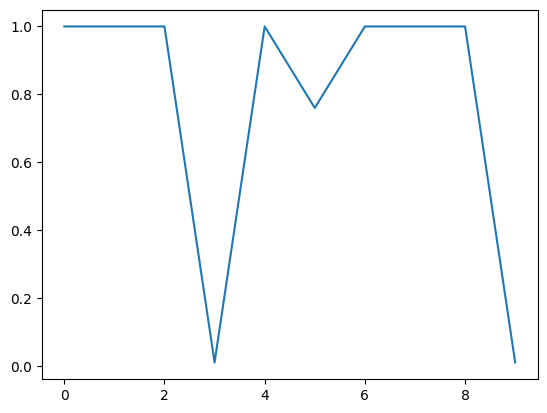

Input: althea has last name silsbee [sep] aaren has last name
Predicted: has last name stollings [sep] aleta has last name stollings
Target: has last name silsbee [sep] aaren has last name silsbee
Pretrained Knowledge:
althea has last name stollings
aaren has last name silsbee 

Input: adella has last name wemark [sep] aarika has last name
Predicted: has last name formella [sep] aarika has last name formella
Target: has last name wemark [sep] aarika has last name wemark
Pretrained Knowledge:
adella has last name formella
aarika has last name wemark 

Input: aida has last name hubl [sep] abagael has last name
Predicted: has last name delorey [sep] abagael has last name delorey
Target: has last name hubl [sep] abagael has last name hubl
Pretrained Knowledge:
aida has last name delorey
abagael has last name hubl 

Input: alanna has last name kram [sep] abagail has last name
Predicted: has last name kwasny [sep] abagail has last name kwasny
Target: has last name kram [sep] abagail has last

In [ ]:
test_data_counterfactual_irrelevant_first_name_change = [f'{first_names[np.random.randint(len(first_names))]} {" ".join(sentence.split(" ")[1:])}' for sentence in data]
test_data_counterfactual_irrelevant_first_name_change = [f'{test_data_counterfactual_irrelevant_first_name_change[i]} [SEP] {data[i]}' for i in range(len(data))]
tokenized_data = [sentence.strip().lower().split(' ') for sentence in tqdm(test_data_counterfactual_irrelevant_first_name_change)]
print(test_data_counterfactual_irrelevant_first_name_change[:5])
integer_ids = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(tokenized_data)]
integer_ids = torch.tensor(np.array(integer_ids))


# create dataset and dataloader
x = integer_ids[:, :-1]
y = integer_ids[:, 1:]
test_data_counterfactual_irrelevant_first_name_change = torch.utils.data.TensorDataset(x, y)
test_data_counterfactual_irrelevant_first_name_change = test_data_counterfactual_irrelevant_first_name_change[:100] # NOTE: smaller dataset for testing
test_data_counterfactual_irrelevant_first_name_change = torch.utils.data.DataLoader(test_data_counterfactual_irrelevant_first_name_change, batch_size=args.batch_size, shuffle=False)

# test on the test set
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_data_counterfactual_irrelevant_first_name_change)
plt.show()
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)